# Team Member

Nguyễn Minh Tuấn - 2470574

Nguyễn Trần Phước - 2470576

Lê Trí Quyền - 2470740

Lê Quang Trung - 2470746

Trần Hoàng Nguyên - 2470739

# Topic 7: Convexity (Section 12.1-12.2): https://d2l.ai/chapter_optimization/index.html  

# 12.1 Optimization and Deep Learning

## Introduction
Loss function is a mathematical function that measures how well a machine learning or deep learning model performs on a given task by quantifying the difference between the model's predictions and the true target values.

Optimization algorithms are the tools that allow us to continue updating model parameters and to minimize the value of the loss function, as evaluated on the training set.

On the one hand, training a complex deep learning model can take hours, days, or even weeks. The performance of the optimization algorithm directly affects the model’s training efficiency. On the other hand, understanding the principles of different optimization algorithms and the role of their hyperparameters will enable us to tune the hyperparameters in a targeted manner to improve the performance of deep learning models.

In [ ]:
!pip install scikit-learn
!pip install torch
!pip install d2l
!pip install torchvision

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## 12.1.1 Goal of optimization

Training Error (Empirical Error): The error of a model on the same data it was trained on. It measures how well the model fits the training data.

Generalization Error (True Error): The expected error of the model on new, unseen data drawn from the same distribution P(x,y). It Measures how well the model generalizes to real-world data.

The goal of optimization is to reduce the training error. However, the goal of deep learning (or more broadly, statistical inference) is to reduce the generalization error.

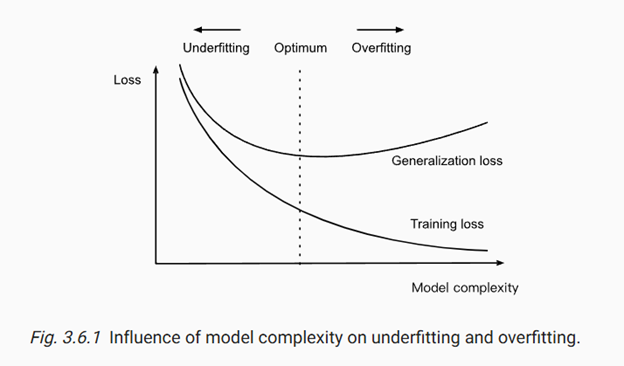

### Example:
empirical risk and true risk

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Generate true distribution (y = 2x + 1 + noise)
X_true = np.linspace(0, 5, 100)
y_true = 2 * X_true + 1 + np.random.normal(scale=1, size=100)

# Small empirical dataset (20 samples)
X_empirical = np.random.uniform(0, 5, 20)
y_empirical = 2 * X_empirical + 1 + np.random.normal(scale=1, size=20)

# Fit linear regression to empirical data
model = LinearRegression()
model.fit(X_empirical.reshape(-1, 1), y_empirical)

# Predictions
y_pred_empirical = model.predict(X_empirical.reshape(-1, 1))
y_pred_true = model.predict(X_true.reshape(-1, 1))

# Calculate risks
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

empirical_risk = mse(y_empirical, y_pred_empirical)
true_risk = mse(y_true, y_pred_true)

# Visualization
plt.figure(figsize=(10, 5))

# True distribution
plt.scatter(X_true, y_true, alpha=0.3, label="True distribution (P)", color='blue')
plt.plot(X_true, 2*X_true+1, '--', label="True function (f*)", color='black')

# Empirical data & model
plt.scatter(X_empirical, y_empirical, label="Empirical data", color='red', zorder=10)
plt.plot(X_true, y_pred_true, label=f"Empirical model (R_emp={empirical_risk:.2f}, R_true={true_risk:.2f})", color='red')

plt.title("Empirical Risk vs. True Risk")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

## 12.1.2 Optimization Challenges in Deep Learning

### 12.1.2.1 Local Minima

For any objective function f(x), if the value of f(x) at m is smaller than the values of f(x) at any other points in the vicinity of m, then f(m) could be a local minimum. If the value of f(x) at m is the minimum of the objective function over the entire domain, then f(m) is the global minimum.

The objective function of deep learning models usually has many local optima.  When the numerical solution of an optimization problem is near the local optimum, the numerical solution may only minimize the objective function locally, rather than globally, as the gradient of the objective function’s solutions approaches or becomes zero.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

#### Example.
Local Minimal: function: f(x) = x.sin(πx) with x in [ - 1 , 2 ]

In [ ]:

# Define the function
def f(x):
    return x * np.sin(np.pi * x)

# Generate data points
x = np.linspace(-1, 2, 500)
y = f(x)

# Find roots and extrema
roots = x[np.abs(y) < 1e-8]  # Approximate roots
critical_points = x[1:-1][np.diff(np.sign(np.diff(y))) != 0]  # Extrema via derivative sign change

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=r'$f(x) = x \sin(\pi x)$', color='blue', linewidth=2)

# Highlight key features
plt.scatter(roots, f(roots), color='red', zorder=5, label='Roots (f(x)=0)')
plt.scatter(critical_points, f(critical_points), color='green', zorder=5, label='Local Extrema')

# Annotate special points
for xp in roots:
    plt.annotate(f'({xp:.1f}, 0)', (xp, 0), textcoords="offset points", xytext=(0,10), ha='center')

for xp in critical_points:
    plt.annotate(f'({xp:.2f}, {f(xp):.2f})',
                (xp, f(xp)),
                textcoords="offset points",
                xytext=(10,-15), ha='left')

# Add reference lines
plt.axhline(0, color='black', linestyle=':', alpha=0.5)
plt.axvline(0, color='black', linestyle=':', alpha=0.5)
plt.axvline(1, color='purple', linestyle='--', alpha=0.5, label='x=1 (Special point)')

plt.title(r'Behavior of $f(x) = x \sin(\pi x)$ on $[-1, 2]$', pad=20)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### 12.1.2.2. Saddle Points

#### Import library for code example in this section

In [ ]:
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [ ]:
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

#### 1. Introduction
##### 1.1. Problem Statement
In optimization problems, especially in deep learning, the goal is to find parameter values for an objective function (typically a loss function) that minimize it. Gradient-based optimization algorithms (e.g., Gradient Descent) navigate the function landscape by moving in the direction opposite to the gradient. A critical point is where the gradient is zero.

A **saddle point** is a critical point that is neither a local minimum nor a local maximum. At a saddle point, the function increases along some dimensions and decreases along others, resembling a horse's saddle.

**The Challenge:** Saddle points are problematic for first-order optimization algorithms. Since the gradient is zero, algorithms might converge slowly or get stuck, mistaking the saddle point for a minimum. In high-dimensional spaces common in deep learning, saddle points are often more prevalent than local minima.

##### 1.2. Applications
Understanding and addressing saddle points is crucial in:
* **Deep Learning:** Training neural networks involves optimizing high-dimensional, non-convex loss functions rife with saddle points.
* **Signal Processing:** Problems like signal recovery.
* **Game Theory:** Finding equilibria.
* **Optimal Control:** Designing efficient controllers.

##### 1.3. Addressing Saddle Points in Computer Science
The study of saddle points has led to more robust optimization methods:
* **Second-order methods:** (e.g., Newton's method) use Hessian information to distinguish saddle points from minima. Costly for large models.
* **Adaptive learning rate algorithms:** (e.g., AdaGrad, RMSProp, Adam) adjust learning rates per parameter, aiding navigation of complex landscapes.
* **Stochasticity and Noise:** Stochastic Gradient Descent (SGD) with mini-batches inherently introduces noise, which can help escape saddle points. Perturbed gradient descent methods add noise intentionally.
* **Exploiting Negative Curvature:** Algorithms that detect and follow directions of negative curvature (if available at a saddle point) to continue descent.

#### 2. Detailed Computations with Concrete Examples

To classify a critical point (where gradient $\nabla f = 0$), we use the Hessian matrix $H$ and its eigenvalues ($\lambda$). The Hessian matrix is a square matrix of second-order partial derivatives of a scalar-valued function. It describes the local curvature of the function.


##### How to Compute the Hessian Matrix
For a function of two variables, $f(x, y)$, the Hessian matrix is defined as:
$$H(x,y) = \begin{pmatrix} \frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\ \frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2} \end{pmatrix}$$

Let's break down each component:

1.  **$\frac{\partial^2 f}{\partial x^2}$:**
    * First, find the partial derivative of $f$ with respect to $x$, treating $y$ as a constant: $\frac{\partial f}{\partial x}$.
    * Then, differentiate this result again with respect to $x$, still treating $y$ as a constant.

2.  **$\frac{\partial^2 f}{\partial y^2}$:**
    * First, find the partial derivative of $f$ with respect to $y$, treating $x$ as a constant: $\frac{\partial f}{\partial y}$.
    * Then, differentiate this result again with respect to $y$, still treating $x$ as a constant.

3.  **$\frac{\partial^2 f}{\partial x \partial y}$:** These are mixed partial derivatives.
    * For $\frac{\partial^2 f}{\partial x \partial y}$: First, find the partial derivative of $f$ with respect to $y$ ($\frac{\partial f}{\partial y}$). Then, differentiate that result with respect to $x$.
    * For $\frac{\partial^2 f}{\partial y \partial x}$: First, find the partial derivative of $f$ with respect to $x$ ($\frac{\partial f}{\partial x}$). Then, differentiate that result with respect to $y$.

**Clairaut's Theorem (Symmetry of Second Derivatives):** For most well-behaved functions (specifically, if the second partial derivatives are continuous), the order of differentiation in mixed partials does not matter. This means:
$$\frac{\partial^2 f}{\partial x \partial y} = \frac{\partial^2 f}{\partial y \partial x}$$
Because of this symmetry, the Hessian matrix is a symmetric matrix.

##### How to Calculate Eigenvalues

Once we have the Hessian matrix $H$ (or any square matrix), its eigenvalues ($\lambda$) can be found by solving the characteristic equation. Here's the process:

1.  **Start with the Eigenvalue Equation:**
    The fundamental equation defining an eigenvalue $\lambda$ and its corresponding non-zero eigenvector $\mathbf{v}$ for a matrix $H$ is:
    $$H\mathbf{v} = \lambda\mathbf{v}$$

2.  **Rearrange the Equation:**
    To solve for $\lambda$, we rearrange the equation:
    $$H\mathbf{v} - \lambda\mathbf{v} = \mathbf{0}$$
    Introduce the identity matrix $I$ (of the same dimensions as $H$) to factor out $\mathbf{v}$:
    $$H\mathbf{v} - \lambda I\mathbf{v} = \mathbf{0}$$
    $$(H - \lambda I)\mathbf{v} = \mathbf{0}$$

3.  **Condition for Non-Trivial Solutions:**
    This is a homogeneous system of linear equations. For a non-zero eigenvector $\mathbf{v}$ to exist (which is required by definition), the matrix $(H - \lambda I)$ must be singular. A singular matrix is one whose determinant is zero.

4.  **Form the Characteristic Equation:**
    Therefore, we set the determinant of $(H - \lambda I)$ to zero:
    $$\det(H - \lambda I) = 0$$
    This equation is called the **characteristic equation** of matrix $H$. It's a polynomial equation in $\lambda$. The degree of the polynomial is equal to the dimension of the matrix $H$.

5.  **Solve for Eigenvalues:**
    The roots of the characteristic equation are the eigenvalues of the matrix $H$.

**Classification using Eigenvalues of the Hessian at a critical point ($\nabla f = 0$):**
* All $\lambda_k > 0$: Local minimum.
* All $\lambda_k < 0$: Local maximum.
* Mixed positive and negative $\lambda_k$: Saddle point.
* Some $\lambda_k = 0$: Inconclusive (requires further analysis).


##### Example 1 (1D): $f(x) = x^3$
This function has a critical point at $x=0$. The first derivative $f'(x) = 3x^2$ is 0 at $x=0$. The second derivative $f''(x) = 6x$ is also 0 at $x=0$. While the second derivative test is inconclusive here for 1D min/max, $x=0$ is an inflection point with a horizontal tangent. It illustrates a scenario where the gradient is zero, but it's not a local extremum, analogous to higher-dimensional saddle points.


In [ ]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

##### Example 2 (2D): $f(x, y) = x^2 - y^2$ (Classic Saddle Point)

This example demonstrates a classic saddle point.

**1. Find Critical Points:**
The first step is to find where the gradient $\nabla f(x,y) = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right)$ is zero.
* $\frac{\partial f}{\partial x} = \frac{\partial}{\partial x}(x^2 - y^2) = 2x$
* $\frac{\partial f}{\partial y} = \frac{\partial}{\partial y}(x^2 - y^2) = -2y$

Set the gradient components to zero:
* $2x = 0 \implies x = 0$
* $-2y = 0 \implies y = 0$
So, the only critical point is $(0,0)$.

**2. The Hessian Matrix $H(x,y)$:**
The Hessian matrix is $H(x,y) = \begin{pmatrix} \frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\ \frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2} \end{pmatrix}$.
* **$\frac{\partial^2 f}{\partial x^2}$**: Differentiate $\frac{\partial f}{\partial x} = 2x$ with respect to $x$:
    $$\frac{\partial^2 f}{\partial x^2} = \frac{\partial}{\partial x}(2x) = 2$$
* **$\frac{\partial^2 f}{\partial y^2}$**: Differentiate $\frac{\partial f}{\partial y} = -2y$ with respect to $y$:
    $$\frac{\partial^2 f}{\partial y^2} = \frac{\partial}{\partial y}(-2y) = -2$$
* **$\frac{\partial^2 f}{\partial x \partial y}$**: Differentiate $\frac{\partial f}{\partial y} = -2y$ with respect to $x$:
    $$\frac{\partial^2 f}{\partial x \partial y} = \frac{\partial}{\partial x}(-2y) = 0$$
* **$\frac{\partial^2 f}{\partial y \partial x}$**: Differentiate $\frac{\partial f}{\partial x} = 2x$ with respect to $y$:
    $$\frac{\partial^2 f}{\partial y \partial x} = \frac{\partial}{\partial y}(2x) = 0$$
So, the Hessian matrix (which is constant for this function) is:
$$H(x,y) = H(0,0) = \begin{pmatrix} 2 & 0 \\ 0 & -2 \end{pmatrix}$$

**3. Eigenvalues for $H = \begin{pmatrix} 2 & 0 \\ 0 & -2 \end{pmatrix}$:**
We solve $\det(H - \lambda I) = 0$.
* $H - \lambda I = \begin{pmatrix} 2 & 0 \\ 0 & -2 \end{pmatrix} - \lambda \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} = \begin{pmatrix} 2-\lambda & 0 \\ 0 & -2-\lambda \end{pmatrix}$
* $\det(H - \lambda I) = (2-\lambda)(-2-\lambda) - (0)(0) = (2-\lambda)(-2-\lambda)$
* Set the determinant to zero: $(2-\lambda)(-2-\lambda) = 0$
* This gives the eigenvalues:
    * $2-\lambda = 0 \implies \lambda_1 = 2$
    * $-2-\lambda = 0 \implies \lambda_2 = -2$

**4. Classification of the Critical Point $(0,0)$:**
Since the eigenvalues are $\lambda_1 = 2$ (positive) and $\lambda_2 = -2$ (negative), the critical point $(0,0)$ is a **saddle point**.

In [ ]:
# Example 2: f(x,y) = x^2 - y^2
def f_example2(x, y):
    return x**2 - y**2

def hessian_f_example2(x, y): # Constant for this function
    return np.array([[2, 0], [0, -2]])

x_c2, y_c2 = 0, 0
H2 = hessian_f_example2(x_c2, y_c2)
eigenvalues2 = np.linalg.eigvals(H2)

print(f"--- Analysis of Example 2: f(x, y) = x^2 - y^2 ---")
print(f"Critical Point: ({x_c2}, {y_c2})")
print(f"  f({x_c2}, {y_c2}) = {f_example2(x_c2, y_c2):.4f}")
print(f"  Hessian matrix at ({x_c2}, {y_c2}):\n{H2}")
print(f"  Eigenvalues of Hessian: {eigenvalues2}")
if np.any(eigenvalues2 > 1e-9) and np.any(eigenvalues2 < -1e-9):
    print(f"  Classification: Saddle Point")
else:
    print(f"  Classification: Check logic or eigenvalues")

# Visualization for Example 2
x_range2 = np.linspace(-2, 2, 50)
y_range2 = np.linspace(-2, 2, 50)
X2, Y2 = np.meshgrid(x_range2, y_range2)
Z2 = f_example2(X2, Y2)

fig2 = plt.figure(figsize=(10, 7))
ax2 = fig2.add_subplot(111, projection='3d')
surf2 = ax2.plot_surface(X2, Y2, Z2, cmap='coolwarm', alpha=0.8, edgecolor='k', linewidth=0.1)
ax2.scatter(0, 0, 0, color='black', s=150, label='(0,0): Saddle Point', depthshade=True, marker='X')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('f(x, y)')
ax2.set_title('Surface of $f(x, y) = x^2 - y^2$ (Classic Saddle Point)')
fig2.colorbar(surf2, shrink=0.5, aspect=5, label='f(x,y)')
ax2.legend()
plt.show()

##### Example 3 (2D): $f(x, y) = x^3 - 3x + y^2 + 2y$

**1. Find Critical Points:**
$\nabla f = (3x^2 - 3, 2y + 2)$.
Set gradient to $(0,0)$:
* $3x^2 - 3 = 0 \implies 3x^2 = 3 \implies x^2 = 1 \implies x = 1$ or $x = -1$.
* $2y + 2 = 0 \implies 2y = -2 \implies y = -1$.
The critical points are $(1, -1)$ and $(-1, -1)$.

**2. The Hessian Matrix $H(x,y)$:**
For $f(x, y) = x^3 - 3x + y^2 + 2y$:
* $\frac{\partial f}{\partial x} = 3x^2 - 3$
* $\frac{\partial f}{\partial y} = 2y + 2$

Now, the second-order partial derivatives:
* **$\frac{\partial^2 f}{\partial x^2}$**: $\frac{\partial}{\partial x}(3x^2 - 3) = 6x$
* **$\frac{\partial^2 f}{\partial y^2}$**: $\frac{\partial}{\partial y}(2y + 2) = 2$
* **$\frac{\partial^2 f}{\partial x \partial y}$**: $\frac{\partial}{\partial x}(2y + 2) = 0$
* **$\frac{\partial^2 f}{\partial y \partial x}$**: $\frac{\partial}{\partial y}(3x^2 - 3) = 0$

So, the Hessian matrix is:
$$H(x,y) = \begin{pmatrix} 6x & 0 \\ 0 & 2 \end{pmatrix}$$

**3. Classification of Critical Points :**

* **For Critical Point $(1, -1)$:**
    * **Hessian at $(1,-1)$:**
        $$H(1,-1) = \begin{pmatrix} 6(1) & 0 \\ 0 & 2 \end{pmatrix} = \begin{pmatrix} 6 & 0 \\ 0 & 2 \end{pmatrix}$$
    * **Eigenvalue Calculation for $H(1,-1)$:**
        Solve $\det(H(1,-1) - \lambda I) = 0$.
        $H(1,-1) - \lambda I = \begin{pmatrix} 6-\lambda & 0 \\ 0 & 2-\lambda \end{pmatrix}$
        $\det(H(1,-1) - \lambda I) = (6-\lambda)(2-\lambda) - 0 = 0$
        Eigenvalues: $\lambda_1 = 6, \lambda_2 = 2$.
    * **Classification:** Both eigenvalues are positive ($6 > 0, 2 > 0$), so $(1, -1)$ is a **local minimum**.

* **For Critical Point $(-1, -1)$:**
    * **Hessian at $(-1,-1)$:**
        $$H(-1,-1) = \begin{pmatrix} 6(-1) & 0 \\ 0 & 2 \end{pmatrix} = \begin{pmatrix} -6 & 0 \\ 0 & 2 \end{pmatrix}$$
    * **Eigenvalue Calculation for $H(-1,-1)$:**
        Solve $\det(H(-1,-1) - \lambda I) = 0$.
        $H(-1,-1) - \lambda I = \begin{pmatrix} -6-\lambda & 0 \\ 0 & 2-\lambda \end{pmatrix}$
        $\det(H(-1,-1) - \lambda I) = (-6-\lambda)(2-\lambda) - 0 = 0$
        Eigenvalues: $\lambda_1 = -6, \lambda_2 = 2$.
    * **Classification:** Eigenvalues have mixed signs ($-6 < 0, 2 > 0$), so $(-1, -1)$ is a **saddle point**.


In [ ]:
# Example 3: f(x, y) = x^3 - 3x + y^2 + 2y
def f_example3(x, y):
    return x**3 - 3*x + y**2 + 2*y

def grad_f_example3(x, y): # For verification
    df_dx = 3*x**2 - 3
    df_dy = 2*y + 2
    return np.array([df_dx, df_dy])

def hessian_f_example3(x, y):
    d2f_dx2 = 6*x
    d2f_dy2 = 2
    d2f_dxdy = 0
    return np.array([[d2f_dx2, d2f_dxdy],
                     [d2f_dxdy, d2f_dy2]])

critical_points_ex3 = [(1, -1), (-1, -1)]
labels_ex3 = ["Local Minimum", "Saddle Point"]
colors_ex3 = ['blue', 'red']
markers_ex3 = ['o', 'X']


print(f"\n--- Analysis of Example 3: f(x, y) = x^3 - 3x + y^2 + 2y ---")
for i, (x_c, y_c) in enumerate(critical_points_ex3):
    print(f"\nCritical Point {i+1}: ({x_c}, {y_c})")
    f_val = f_example3(x_c, y_c)
    print(f"  f({x_c}, {y_c}) = {f_val:.4f}")
    grad_val = grad_f_example3(x_c, y_c) # Should be [0,0]
    print(f"  Gradient at ({x_c}, {y_c}): {grad_val}")

    H = hessian_f_example3(x_c, y_c)
    eigenvalues = np.linalg.eigvals(H)
    print(f"  Hessian matrix at ({x_c}, {y_c}):\n{H}")
    print(f"  Eigenvalues of Hessian: {eigenvalues}")

    if np.all(eigenvalues > 1e-9):
        print(f"  Classification: Local Minimum (Matches: {labels_ex3[i]})")
    elif np.all(eigenvalues < -1e-9):
        print(f"  Classification: Local Maximum") # Not expected for this example
    elif np.any(eigenvalues > 1e-9) and np.any(eigenvalues < -1e-9):
        print(f"  Classification: Saddle Point (Matches: {labels_ex3[i]})")
    else:
        print(f"  Classification: Inconclusive (Matches: {labels_ex3[i]})")


# Visualization for Example 3
x_range3 = np.linspace(-2.5, 2.5, 100)
y_range3 = np.linspace(-3, 1, 100)
X3, Y3 = np.meshgrid(x_range3, y_range3)
Z3 = f_example3(X3, Y3)

fig3 = plt.figure(figsize=(12, 8))
ax3 = fig3.add_subplot(111, projection='3d')
surf3 = ax3.plot_surface(X3, Y3, Z3, cmap='viridis', alpha=0.7, edgecolor='k', linewidth=0.1, rstride=5, cstride=5) # rstride/cstride for performance

for i, (x_c, y_c) in enumerate(critical_points_ex3):
    f_c = f_example3(x_c, y_c)
    ax3.scatter(x_c, y_c, f_c, color=colors_ex3[i], s=150, label=f'({x_c},{y_c}): {labels_ex3[i]}', depthshade=True, marker=markers_ex3[i])

ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('f(x, y)')
ax3.set_title('Surface of $f(x,y) = x^3 - 3x + y^2 + 2y$ and Critical Points')
fig3.colorbar(surf3, shrink=0.5, aspect=5, label='f(x,y)')

# Handle legend to avoid duplicates if any (though direct labeling is fine here)
handles, labels_legend = ax3.get_legend_handles_labels()
by_label = dict(zip(labels_legend, handles))
ax3.legend(by_label.values(), by_label.keys())

plt.show()

### 12.1.2.3. Vanishing Gradients


#### 1. Introduction

##### 1.1. Problem Statement: What are Vanishing Gradients?
The **vanishing gradient problem** is a significant challenge encountered during the training of deep artificial neural networks. It refers to the phenomenon where the gradients of the loss function with respect to the weights in the earlier layers of the network become exceedingly small (i.e., they "vanish").

When these gradients are very close to zero, the updates to the weights during backpropagation become minuscule. Consequently, the earlier layers of the network learn very slowly, or sometimes not at all. This is problematic because these initial layers are often responsible for learning fundamental, low-level features from the input data, which are crucial for the subsequent layers to build upon.

The d2l.ai book (Section 12.1.2.3) highlights this with an example: when minimizing a function like $f(x) = \tanh(x)$, if the starting point is far from the origin (e.g., $x=4$), the gradient $f'(x)$ is already very small, making optimization progress extremely slow. This effect is compounded in deep networks.

##### 1.2. Impact on Deep Learning
Historically, the vanishing gradient problem was a major obstacle to training truly deep neural networks. Before effective solutions were widely adopted, it limited the depth of networks that could be trained successfully, as deeper networks were more susceptible to this issue.

#### 2. Why Vanishing Gradients Occur

Several factors contribute to the vanishing gradient problem, especially in deep networks:

##### 2.1. Activation Functions
Certain activation functions, which were popular in earlier neural networks, have derivatives that saturate (become very small) for large input values (either positive or negative).
* **Sigmoid Function ($\sigma(x) = \frac{1}{1+e^{-x}}$):** Its derivative is $\sigma'(x) = \sigma(x)(1-\sigma(x))$. The maximum value of this derivative is 0.25 (at $x=0$). For inputs far from 0, the derivative approaches 0.
* **Hyperbolic Tangent Function ($\tanh(x)$):** Its derivative is $\text{sech}^2(x) = 1 - \tanh^2(x)$. The maximum value of this derivative is 1 (at $x=0$). For inputs far from 0 (e.g., $|x| > 3$), the derivative also approaches 0.

##### 2.2. The Chain Rule in Backpropagation
In a deep neural network, the gradient for a weight in an early layer is calculated by multiplying many terms together via the chain rule during backpropagation. These terms include the derivatives of the activation functions in subsequent layers and the weights of those layers.

If a network has many layers, and many of these multiplicative terms are small (e.g., derivatives of sigmoid/tanh functions in their saturation regions, or weights with magnitudes less than 1), their product can decrease exponentially, leading to an extremely small gradient for the initial layers.

Consider a simplified scenario: if you have $L$ layers and the average magnitude of the relevant derivative terms is $d_avg < 1$, the gradient signal for the first layer might be scaled by a factor roughly proportional to $(d_{avg})^L$. If $d_{avg}$ is significantly less than 1 and $L$ is large, this factor becomes vanishingly small.

#### 3. Consequences of Vanishing Gradients

* **Slow Training:** The most direct consequence is that the weights in the early layers of the network are updated very slowly, significantly prolonging the training time.
* **Poor Performance / Ineffective Learning:** Because the early layers fail to learn meaningful feature representations from the data, the overall model performance suffers. The network essentially becomes "stuck" as the deeper layers cannot compensate for the lack of good initial features.
* **Difficulty in Training Deep Networks:** It makes training very deep networks practically impossible with traditional activation functions and initialization schemes.

#### 4. Illustrative Examples

##### 4.1. Derivative of the `tanh` function
The `tanh` function and its derivative illustrate how gradients can become small.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch # Still used for a point-wise derivative example later if desired

# --- Using NumPy for tanh and its derivative ---
x_np = np.linspace(-7, 7, 400)
tanh_x_np = np.tanh(x_np)
dtanh_x_np = 1 - tanh_x_np**2 # Derivative of tanh(x) is 1 - tanh^2(x)

plt.figure(figsize=(12, 5)) # Adjusted figsize as we only have one row of plots now

plt.subplot(1, 2, 1)
plt.plot(x_np, tanh_x_np, label='tanh(x)')
plt.title('tanh(x) Function (NumPy)')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_np, dtanh_x_np, label="Derivative: 1 - tanh^2(x)", color='orange')
plt.title('Derivative of tanh(x) (NumPy)')
plt.xlabel('x')
plt.ylabel("f'(x)")
plt.grid(True)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
# Highlight regions where derivative is small
plt.fill_between(x_np, 0, dtanh_x_np, where=(np.abs(x_np) > 2.5), color='orange', alpha=0.3, label='Small gradient region')
plt.legend()

plt.tight_layout()
plt.show()

print("--- NumPy Calculations ---")
print(f"Value of tanh(4) = {np.tanh(4):.4f}")
print(f"Derivative of tanh(x) at x=4: {1 - np.tanh(4)**2:.4f}")
print(f"Value of tanh(-5) = {np.tanh(-5):.4f}")
print(f"Derivative of tanh(x) at x=-5: {1 - np.tanh(-5)**2:.4f}")



##### 4.2. Vanishing Gradient Problem with Sigmoid

**How Sigmoid Contributes to Vanishing Gradients:**

1.  **Derivative of the Sigmoid Function:**
    As we've seen, the derivative of the Sigmoid function $S(x) = \frac{1}{1 + e^{-x}}$ is:
    $$S'(x) = S(x)(1 - S(x))$$

2.  **Maximum Value of the Derivative:**
    The maximum value of $S'(x)$ is $0.25$. This occurs at $x=0$, where $S(x)=0.5$, so $S'(0) = 0.5(1-0.5) = 0.25$.

3.  **Derivative in Saturated Regions:**
    When the input $x$ to the Sigmoid function is very large (positive or negative), the Sigmoid function "saturates" (its output $S(x)$ gets very close to 1 or 0):
    * If $x$ is large and positive, $S(x) \approx 1$. Then $S'(x) \approx 1(1-1) = 0$.
    * If $x$ is large and negative (e.g., $x < -5$), $S(x) \approx 0$. Then $S'(x) \approx 0(1-0) = 0$.
    In these saturated regions, the local gradient $S'(x)$ is very close to zero.

4.  **Gradient Propagation in Deep Networks:**
    In a deep neural network, the gradient of the loss with respect to a weight in an early layer is a product of many terms, including the local gradients of the activation functions in all subsequent layers.
    If we have $L$ layers using Sigmoid activations, the gradient signal for an early layer might be scaled by a factor roughly proportional to:
    $$S'(z_L) \times S'(z_{L-1}) \times \dots \times S'(z_1)$$
    where $S'(z_i)$ is the derivative of the Sigmoid function at the input $z_i$ of layer $i$.

    Since each $S'(z_i) \le 0.25$, multiplying many such terms together will cause the product to decrease exponentially:
    * If all $S'(z_i)$ are at their maximum of $0.25$, then for $L$ layers, the product is $(0.25)^L$.
    * For $L=5$, $(0.25)^5 \approx 0.000976$.
    * For $L=10$, $(0.25)^{10} \approx 9.5 \times 10^{-7}$.
    * If any of the Sigmoid units are in their saturated regions, their local gradients $S'(z_i)$ will be much smaller than $0.25$, making the overall product even tinier and vanish even faster.

**Consequences:**
* **Slow Training:** Initial layers learn extremely slowly or get stuck.
* **Poor Performance:** The network fails to learn complex patterns that require deep representations.

**Reference:**
https://www.kdnuggets.com/2022/02/vanishing-gradient-problem.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s_x = sigmoid(x)
    return s_x * (1 - s_x)

# 1. Plot the Sigmoid derivative to visualize its range
x_vals_prime = np.linspace(-10, 10, 400)
s_prime_vals = sigmoid_prime(x_vals_prime)

plt.figure(figsize=(8, 5))
plt.plot(x_vals_prime, s_prime_vals, label="$S'(x) = S(x)(1-S(x))$")
plt.title("Derivative of the Sigmoid Function $S'(x)$")
plt.xlabel("x (Input to Sigmoid)")
plt.ylabel("$S'(x)$ (Local Gradient)")
plt.axhline(0.25, color='red', linestyle='--', label='Max value = 0.25')
plt.axhline(0, color='black', linestyle='-', lw=0.5)
plt.axvline(0, color='gray', linestyle='--', lw=0.5)
plt.legend()
plt.grid(True)
plt.ylim(-0.05, 0.3) # Adjusted ylim to better see the curve
plt.show()

# 2. Demonstrate gradient values at different points
print("--- Local Gradients (S'(x)) at different input values x ---")
x_points = np.array([-7, -5, -2, 0, 2, 5, 7]) # Inputs to Sigmoid units in a hypothetical network
local_gradients_at_points = sigmoid_prime(x_points) # Renamed to avoid conflict

for i, x_val in enumerate(x_points):
    print(f"For input x = {x_val:5.1f}, S(x) = {sigmoid(x_val):.4f}, S'(x) (local gradient) = {local_gradients_at_points[i]:.6f}")

# 3. Simulate and Plot Gradient Decay over Layers
print("\n--- Simulated Gradient Decay over Hypothetical Layers ---")

num_layers_max = 15 # Max number of layers to simulate for the plot
layers = np.arange(1, num_layers_max + 1)

# Scenarios for average local gradient values
scenarios = {
    "Best Case (local grad=0.25)": 0.25,
    "Moderate Case (local grad=0.15)": 0.15,
    "Poor Case (local grad=0.05)": 0.05,
    "Saturated (local grad=0.01)": 0.01
}

plt.figure(figsize=(10, 6))

for scenario_name, avg_local_gradient in scenarios.items():
    overall_gradient_factors = avg_local_gradient ** layers
    plt.plot(layers, overall_gradient_factors, marker='o', linestyle='-', label=f'{scenario_name}')
    # Print the last value for each scenario for comparison with previous text output
    if layers.size > 0: # Ensure layers is not empty
        print(f"Scenario: {scenario_name}")
        for l_idx, l_val in enumerate(layers):
            if l_val in [1, 3, 5, 10, 15]: # Print for specific layers
                 print(f"  After {l_val} layers, gradient factor ~ ({avg_local_gradient})^{l_val} = {overall_gradient_factors[l_idx]:.8e}")


plt.title("Simulated Gradient Factor Decay Across Layers")
plt.xlabel("Number of Layers")
plt.ylabel("Overall Gradient Factor (Magnitude)")
plt.xticks(layers) # Show all layer numbers if not too many, or adjust as needed
plt.yscale('log') # Use log scale for y-axis to better visualize rapid decay
plt.legend()
plt.grid(True, which="both", ls="--") # Grid for both major and minor ticks on log scale
plt.ylim(bottom=1e-15) # Set a bottom limit for y-axis, especially for log scale
plt.show()

print("\nThe graph above visually demonstrates how quickly the gradient signal can diminish (vanish)")
print("as it propagates backward through increasing numbers of layers, especially when the")
print("local gradients (from Sigmoid derivatives) are small.")
print("Note the logarithmic scale on the y-axis to accommodate the rapid decrease.")

#### 5. Conclusion

The vanishing gradient problem is a critical hurdle in training deep neural networks, stemming from the multiplicative effect of small derivatives during backpropagation, often exacerbated by certain activation functions. It leads to slow or stalled learning in the early layers of a network. Understanding this issue has spurred the development of various effective mitigation techniques, such as better activation functions (ReLU), improved weight initialization, normalization layers, and innovative network architectures (ResNets, LSTMs). These advancements have been pivotal in enabling the training of much deeper and more powerful neural networks.

## 12.1.3 Exercise

### Exercise 1
 Consider a simple MLP with a single hidden layer of, say, $d$ dimensions in the hidden layer and a single output. Show that for any local minimum there are at least $d!$ equivalent solutions that behave identically.

Let:
- $( \mathbf{x} \in \mathbb{R}^n $): input vector
- $( \mathbf{W}_1 \in \mathbb{R}^{d \times n} $): input-to-hidden weights
- $( \mathbf{b}_1 \in \mathbb{R}^d $): hidden layer bias
- $( \phi $): nonlinear activation function (applied element-wise)
- $( \mathbf{W}_2 \in \mathbb{R}^{1 \times d} $): hidden-to-output weights
- $( b_2 \in \mathbb{R} $): output bias

The MLP function is:

$[
f(\mathbf{x}) = \mathbf{W}_2 \cdot \phi(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + b_2
$]

---

#### Permutation Symmetry

Let $( \pi $) be a permutation of the \( d \) hidden units.

Define a **permutation matrix** $( P_\pi \in \mathbb{R}^{d \times d} $), such that:

- $( \mathbf{W}_1' = P_\pi \mathbf{W}_1 $)
- $( \mathbf{b}_1' = P_\pi \mathbf{b}_1 $)
- $( \mathbf{W}_2' = \mathbf{W}_2 P_\pi^\top $)

Then the permuted network computes:

\[
\begin{align*}
f'(\mathbf{x}) &= \mathbf{W}_2' \cdot \phi(\mathbf{W}_1' \mathbf{x} + \mathbf{b}_1') + b_2 \\
&= \mathbf{W}_2 P_\pi^\top \cdot \phi(P_\pi \mathbf{W}_1 \mathbf{x} + P_\pi \mathbf{b}_1) + b_2 \\
&= \mathbf{W}_2 \cdot \phi(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + b_2 = f(\mathbf{x})
\end{align*}
\]

So the function remains **unchanged** under such a permutation.

In [ ]:
import torch
import torch.nn as nn
import numpy as np

torch.manual_seed(0)  # For reproducibility

# Define parameters
d = 4            # Number of neurons in hidden layer
n_input = 3      # Input feature dimension
n_samples = 5    # Number of input samples

# Generate random input data: shape (5 samples, 3 features)
x = torch.randn(n_samples, n_input)

# ---- Original MLP Weights and Biases ----
# First layer: maps input (3D) to hidden layer (4D)
W1 = torch.randn(d, n_input)   # Shape: (4, 3)
b1 = torch.randn(d)            # Shape: (4,)

# Second layer: maps hidden layer (4D) to output (1D)
W2 = torch.randn(1, d)         # Shape: (1, 4)
b2 = torch.randn(1)            # Shape: (1,)

# ---- Original Network Output Function ----
def original_net(x):
    hidden = torch.relu(x @ W1.T + b1)  # Apply ReLU to hidden activations
    output = hidden @ W2.T + b2         # Compute output
    return output

# Get output from original network
y_orig = original_net(x)

# ---- Create a Permutation of the Hidden Layer ----
# This swaps hidden neurons arbitrarily
perm = torch.randperm(d)           # A random permutation of [0, 1, 2, ..., d-1]

# Apply the permutation:
# - Reorder rows of W1 (each row is a hidden neuron’s weights)
# - Reorder b1 entries (bias for each hidden neuron)
# - Reorder columns of W2 (weights from hidden neurons to output)
W1_perm = W1[perm]
b1_perm = b1[perm]
W2_perm = W2[:, perm]

# ---- Permuted Network Output Function ----
def permuted_net(x):
    hidden = torch.relu(x @ W1_perm.T + b1_perm)
    output = hidden @ W2_perm.T + b2  # Note: same output bias b2
    return output

# Get output from permuted network
y_perm = permuted_net(x)

# ---- Check if both outputs are identical ----
# The outputs should be exactly the same because permutation doesn't affect result
difference = torch.norm(y_orig - y_perm).item()
print("Difference between original and permuted output:", difference)


### Exercise 2
Assume that we have a symmetric random matrix $M$ where the entries $M_{ij} = M_{ji}$ are each drawn from some probability distribution $p_{ij}$. Furthermore, assume that $p_{ij}(x) = p_{ij}(-x)$, i.e., that the distribution is symmetric (see e.g., Wigner (1958) for details).

1.  Prove that the distribution over eigenvalues is also symmetric. That is, for any eigenvector $v$, the probability that the associated eigenvalue $\lambda$ satisfies $P(\lambda > 0) = P(\lambda < 0)$.
2.  Why does the above *not* imply $P(\lambda > 0) = 0.5$?

#### 1: Proving $P(\lambda > 0) = P(\lambda < 0)$

##### Step 1: Consider the Matrix $-M$
we take our original matrix $M$ and create a new matrix, called $-M$, by multiplying every entry in $M$ by -1.

##### Step 2: Statistical Properties of $-M$
Since the probability distribution for each entry $M_{ij}$ is symmetric (i.e., $p_{ij}(x) = p_{ij}(-x)$), the probability of $M_{ij}$ being some value $x$ is the same as it being $-x$.
This means that an entry $-M_{ij}$ (from the matrix $-M$) will have the exact same probability distribution as an entry $M_{ij}$ (from the matrix $M$).
Therefore, the matrix $-M$ is statistically indistinguishable from the matrix $M$. They both belong to the same "family" of random matrices, generated by the same underlying probability rules.

##### Step 3: Eigenvalues of $M$ versus $-M$
Let $\lambda$ be an eigenvalue of $M$. This means there's a non-zero vector $v$ (an eigenvector) such that $Mv = \lambda v$.
Now, let's look at what happens with $-M$:
$$ (-M)v = -(Mv) = -(\lambda v) = (-\lambda)v $$
This equation shows that if $\lambda$ is an eigenvalue of $M$, then $-\lambda$ must be an eigenvalue of $-M$ (with the same eigenvector $v$).

##### Step 4: Symmetry in the Eigenvalue Distribution
We established two key points:
1.  The matrices $M$ and $-M$ are statistically identical (they follow the same probability distribution for their creation).
2.  If $\lambda$ is an eigenvalue of $M$, then $-\lambda$ is an eigenvalue of $-M$.

Since $M$ and $-M$ are drawn from the same statistical process, their sets of eigenvalues must also follow the same overall probability distribution.
This means that the distribution of eigenvalues for $M$ must be the same as the distribution of eigenvalues for $-M$.
If the set of typical eigenvalues for $M$ is $\{\lambda_1, \lambda_2, \dots \lambda_n\}$, then the set of typical eigenvalues for $-M$ is $\{-\lambda_1, -\lambda_2, \dots -\lambda_n\}$.
For these two sets to have the same distribution, the distribution of $\lambda$ itself must be symmetric around 0. In simpler terms, the probability of observing an eigenvalue $\lambda_{val}$ must be the same as observing an eigenvalue $-\lambda_{val}$.

##### Step 5: Conclusion for Part 1
If the overall distribution of eigenvalues $\lambda$ is symmetric around 0, it directly implies that the total probability of eigenvalues being positive must equal the total probability of eigenvalues being negative.

Therefore, we can conclude that:
$$ P(\lambda > 0) = P(\lambda < 0) $$

#### 2: Why $P(\lambda > 0) = P(\lambda < 0)$ Does Not Imply $P(\lambda > 0) = 0.5$

##### Step 1: The Three Possibilities for an Eigenvalue
Any eigenvalue $\lambda$ can be classified in one of three ways:
1.  **Positive**: $\lambda > 0$
2.  **Negative**: $\lambda < 0$
3.  **Zero**: $\lambda = 0$

These three possibilities are mutually exclusive (an eigenvalue can't be positive and negative at the same time) and exhaustive (there are no other options).

##### Step 2: Probabilities Must Add Up to 1
The sum of the probabilities of all possible outcomes must be 1 (or 100%). So:
$$ P(\lambda > 0) + P(\lambda < 0) + P(\lambda = 0) = 1 $$

##### Step 3: Using the Result from Part 1
From Part 1, we know that $P(\lambda > 0) = P(\lambda < 0)$. Let's call this common probability value '$X$'.
So, $P(\lambda > 0) = X$ and $P(\lambda < 0) = X$.

Substituting these into the equation from Step 2:
$$ X + X + P(\lambda = 0) = 1 $$
This simplifies to:
$$ 2X + P(\lambda = 0) = 1 $$

##### Step 4: Solving for $X$ (which is $P(\lambda > 0)$)
We want to find an expression for $X$. Rearranging the equation from Step 3:
$$ 2X = 1 - P(\lambda = 0) $$
Dividing by 2:
$$ X = \frac{1 - P(\lambda = 0)}{2} $$
Since $X = P(\lambda > 0)$, we have:
$$ P(\lambda > 0) = \frac{1 - P(\lambda = 0)}{2} $$

##### Step 5: When Would $P(\lambda > 0)$ Be Equal to 0.5?
For $P(\lambda > 0)$ to be equal to $0.5$, we would need:
$$ 0.5 = \frac{1 - P(\lambda = 0)}{2} $$
Multiply both sides by 2:
$$ 1 = 1 - P(\lambda = 0) $$
For this equation to hold true, $P(\lambda = 0)$ must be 0:
$$ P(\lambda = 0) = 0 $$

##### Step 6: The Key Reason and Conclusion
The equation $P(\lambda > 0) = \frac{1 - P(\lambda = 0)}{2}$ shows that $P(\lambda > 0)$ depends on $P(\lambda = 0)$.

$P(\lambda > 0)$ is equal to $0.5$ **only if** the probability of an eigenvalue being exactly zero ($P(\lambda = 0)$) is itself $0$.

If there is any chance that an eigenvalue can be zero (i.e., if $P(\lambda = 0) > 0$), then $1 - P(\lambda = 0)$ will be less than 1. Consequently, $\frac{1 - P(\lambda = 0)}{2}$ will be less than $0.5$.

Therefore, even though $P(\lambda > 0) = P(\lambda < 0)$, neither of these probabilities has to be $0.5$ if there's a non-zero chance that $\lambda = 0$.

#### Overall Conclusion

1.  The symmetry of the probability distribution of the entries in a symmetric random matrix $M$ leads to a symmetric distribution for its eigenvalues, meaning $P(\lambda > 0) = P(\lambda < 0)$.
2.  This equality does not force $P(\lambda > 0)$ to be $0.5$ because the possibility of eigenvalues being exactly zero ($P(\lambda = 0)$) must be accounted for. If $P(\lambda = 0) > 0$, then $P(\lambda > 0)$ will be less than $0.5$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters for the simulation ---
matrix_dim = 2      # Dimension of the square symmetric matrix (e.g., 2x2)
num_matrices = 20000 # Number of random matrices to generate for statistics

entry_values = np.array([-1, 0, 1])
entry_probabilities = np.array([0.3, 0.4, 0.3]) # Sum must be 1

# --- Simulation ---
all_eigenvalues = []

print(f"Generating {num_matrices} random {matrix_dim}x{matrix_dim} symmetric matrices...")
for _ in range(num_matrices):
    matrix = np.zeros((matrix_dim, matrix_dim))
    for i in range(matrix_dim):
        for j in range(i, matrix_dim): # Fill upper triangle and diagonal
            sample = np.random.choice(entry_values, p=entry_probabilities)
            matrix[i, j] = sample
            if i != j: # Ensure symmetry by copying to lower triangle
                matrix[j, i] = sample

    eigenvalues = np.linalg.eigvalsh(matrix) # For real symmetric matrices
    all_eigenvalues.extend(eigenvalues)

all_eigenvalues = np.array(all_eigenvalues)
print("Simulation complete.")

# --- Analysis for Part 1: Symmetry of Eigenvalue Distribution ---
# Define a small tolerance for comparing eigenvalues to zero numerically
epsilon = 1e-9

# Categorize non-zero eigenvalues
positive_eigenvalues = all_eigenvalues[all_eigenvalues > epsilon]
negative_eigenvalues = all_eigenvalues[all_eigenvalues < -epsilon]

num_positive = len(positive_eigenvalues)
num_negative = len(negative_eigenvalues)
total_eigenvalues_count = len(all_eigenvalues)

# Calculate empirical probabilities for non-zero parts
if total_eigenvalues_count > 0:
    prob_lambda_gt_0 = num_positive / total_eigenvalues_count
    prob_lambda_lt_0 = num_negative / total_eigenvalues_count
else:
    prob_lambda_gt_0 = 0
    prob_lambda_lt_0 = 0

# --- Plotting for Part 1 (Histogram Only) ---
plt.style.use('seaborn-v0_8-whitegrid') # You can change or remove this style if preferred

plt.figure(figsize=(10, 6)) # Adjusted figsize for a single, clear plot
plt.hist(all_eigenvalues, bins=100, density=True, color='deepskyblue', edgecolor='black', alpha=0.7)
plt.title(f'Distribution of All Eigenvalues\n(Illustrating Symmetry for Part 1)', fontsize=16)
plt.xlabel('Eigenvalue (λ)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='λ = 0')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


### Exercise 3
What other challenges involved in deep learning optimization can you think of?

#### Exploding Gradients

**What it is:** The opposite of vanishing gradients. Gradients become excessively large during backpropagation.

**Why it's a problem:** Large gradients cause large weight updates, leading to unstable training. The optimizer might overshoot optimal points, the loss might oscillate wildly, or weights can grow so large they result in numerical overflow (`NaN` or `Inf` values), halting training.

**Common approaches:** Gradient clipping (scaling down gradients if their norm exceeds a threshold), careful weight initialization, weight regularization, and using LSTM/GRU cells in RNNs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gradient_propagation(num_steps, initial_gradient, weight_factor):
    gradient_magnitudes = [initial_gradient]
    current_gradient = initial_gradient
    for _ in range(num_steps):
        current_gradient *= weight_factor
        # Cap/floor for practical plotting (real overflow/underflow would be NaN/Inf or precision loss)
        if np.isinf(current_gradient) or np.abs(current_gradient) > 1e38: current_gradient = np.sign(current_gradient) * 1e38 if current_gradient != 0 else 1e38
        elif np.abs(current_gradient) < 1e-38 and current_gradient != 0: current_gradient = np.sign(current_gradient) * 1e-38
        gradient_magnitudes.append(current_gradient)
    return gradient_magnitudes

num_backward_steps = 25
initial_gradient_magnitude = 1.0

gradients_explode = simulate_gradient_propagation(num_backward_steps, initial_gradient_magnitude, 1.2) # Factor > 1
gradients_stable = simulate_gradient_propagation(num_backward_steps, initial_gradient_magnitude, 1.0)  # Factor = 1
gradients_vanish = simulate_gradient_propagation(num_backward_steps, initial_gradient_magnitude, 0.8) # Factor < 1
steps = list(range(num_backward_steps + 1))

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(steps, gradients_explode, marker='o', linestyle='-', color='red', label='Exploding (Factor = 1.2)')
plt.plot(steps, gradients_stable, marker='s', linestyle='--', color='green', label='Stable (Factor = 1.0)')
plt.plot(steps, gradients_vanish, marker='x', linestyle=':', color='blue', label='Vanishing (Factor = 0.8)')
plt.title('Conceptual Gradient Magnitude Propagation', fontsize=15)
plt.xlabel('Number of Steps Backward (from output)', fontsize=12)
plt.ylabel('Gradient Magnitude (Log Scale)', fontsize=12)
plt.yscale('log')
plt.xticks(np.arange(0, num_backward_steps + 1, 5))
plt.legend(fontsize=10)
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Exercise 4
Assume that you want to balance a (real) ball on a (real) saddle.

Why is this hard?

Can you exploit this effect also for optimization algorithms?

#### Why is Balancing a Ball on a Saddle Hard?

A **saddle surface** $( z = x^2 - y^2 $) curves:

- **Upward in one direction** (e.g. along the x-axis),
- **Downward in another direction** (e.g. along the y-axis).

So, placing a ball at the center of the saddle:

- It **rolls down** along the downward-curved direction,
- It’s **trapped or balanced** in the upward-curved direction.

This makes the saddle **unstable**:  
> A tiny perturbation in the wrong direction (downward slope) causes the ball to accelerate away from the center.

This is **why balancing a real ball on a saddle is difficult**—small deviations lead to large, uncontrollable motion.

#### Can We Exploit Saddle Geometry in Optimization?

Yes — understanding saddle geometry helps us design **better optimization algorithms**.

- Since saddle points have **negative curvature** in some directions, we can:
  - Use **second-order methods** (e.g. Newton’s method) that detect negative curvature.
  - Add **noise** (as in SGD or Langevin dynamics) to escape flat saddle regions.
  - Use algorithms like **Adam, RMSprop** that adapt learning rates directionally.

##### Practical Strategies:
- **Momentum** helps push through flat regions or escape slow convergence at saddles.
- **Hessian-vector products** (used in trust-region or curvature-aware methods) can detect and escape saddles.

So, just as a ball **naturally escapes** a saddle if nudged in the right direction,  
**algorithms can exploit negative curvature** to avoid getting stuck during training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a saddle function: f(x, y) = x^2 - y^2
def f(x, y):
    return x**2 - y**2

# Compute gradient
def grad(x, y):
    return np.array([2*x, -2*y])

# Gradient descent on the saddle
def gradient_descent(start, lr=0.1, steps=20):
    path = [start]
    x, y = start
    for _ in range(steps):
        g = grad(x, y)
        x -= lr * g[0]
        y -= lr * g[1]
        path.append((x, y))
    return np.array(path)

# Start near the saddle point at (0, 0)
path = gradient_descent(start=(1.0, 0.5), lr=0.1, steps=20)

# Plot surface and path
X, Y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
Z = f(X, Y)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.6)
ax.plot(path[:, 0], path[:, 1], f(path[:, 0], path[:, 1]), color='black', marker='o', label="Gradient Descent Path")
ax.set_title('Gradient Descent on a Saddle Surface')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.legend()
plt.show()


# 12.2 Convexity

In [ ]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## 12.2.1. Introduction to Convexity

### 12.2.1.1 Problem Statement

In optimization theory and computational algorithms, finding efficient and reliable methods for solving complex problems remains a significant challenge. A major issue is that many real-world optimization problems are inherently **nonconvex**, containing multiple local minima, making it hard to guarantee global optimality.

Convexity simplifies this challenge considerably: a **convex optimization problem has no local minima except for the global one**. Hence, understanding and exploiting convexity becomes crucial.

A set $( \mathcal{X} $) is **convex** if for any two points $( a, b \in \mathcal{X} $), the line segment $( \lambda a + (1 - \lambda)b $) for $( \lambda \in [0,1] $) also belongs to $( \mathcal{X} $).

Convex functions \( f: \mathcal{X} \to \mathbb{R} \) have a similar property:  
$[
f(\lambda x + (1 - \lambda)x') \leq \lambda f(x) + (1 - \lambda)f(x')
$]

These properties make convex optimization problems easier to analyze, solve, and verify correctness.

---

### 12.2.1.2 Applications

Convexity is widely used in many fields due to its desirable properties:

- **Machine Learning & Deep Learning**:  
  Optimization algorithms are validated on convex problems. Though neural networks are nonconvex, local convexity near minima supports effective convergence using SGD or Adam.

- **Probabilistic Models**:  
  **Jensen’s Inequality**, a key tool in convex analysis, is used in **variational inference**, enabling tractable approximations of complex likelihoods (e.g., in clustering or latent variable models).

- **Signal & Image Processing**:  
  Convex optimization is used in **compressed sensing** and **denoising** tasks by minimizing norms like $( \ell_1 $) to recover sparse signals.

- **Economics & Operations Research**:  
  Resource allocation, logistics, and finance problems are efficiently solved using convex formulations (e.g., **portfolio optimization**).

- **Control & Systems Theory**:  
  Robust control and trajectory optimization benefit from convex guarantees on stability and performance.

---

### 12.2.1.3 How Some CS Problems Have Been Solved Using Convexity Methods

- **Support Vector Machines (SVMs)**:  
  The optimization of SVMs is a **convex quadratic program**, leading to global optimal solutions for classification problems.

- **Compressed Sensing**:  
  Sparse signal recovery is posed as an **$( \ell_1 $)-minimization problem**, a convex formulation that allows exact recovery from limited data.

- **Variational Inference**:  
  Using **Jensen’s Inequality**, one can bound complex expressions like the log-likelihood, facilitating tractable approximations in models like VAEs.

- **Network Optimization**:  
  Problems such as **routing, congestion control**, and **resource scheduling** are solved via convex formulations, ensuring efficiency and scalability.

- **Optimization Algorithms**:  
  Even when deep learning is nonconvex, convexity-based theory helps in designing algorithms (e.g., SGD, RMSProp) that converge well in practice by leveraging **local convexity**.
---

### 12.2.1.4 Definition of Convex Sets, Convex Functions, and Jensen's Inequality

#### **Convex Sets**

A **convex set** is a set $( S $) in a vector space that satisfies the following condition: for any two points $( x_1, x_2 \in S $), the line segment connecting these two points lies entirely within the set $( S $). Mathematically:

$[
\text{For all} \, x_1, x_2 \in S \, \text{and} \, \lambda \in [0, 1], \quad \lambda x_1 + (1-\lambda) x_2 \in S
$]

This means that if you pick two points inside the set, every point on the straight line between them will also be inside the set.

#### **Convex Functions**

A function $( f $) is said to be **convex** on a domain $( D $) if, for any two points $( x_1, x_2 \in D $) and any $( \lambda \in [0, 1] $), the following inequality holds:

$[
f(\lambda x_1 + (1-\lambda) x_2) \leq \lambda f(x_1) + (1-\lambda) f(x_2)
$]

This property means that the **line segment** between any two points on the graph of the function lies **above** or **on** the graph itself, creating a "bowl-shaped" curve.

- **Example**: The function $( f(x) = x^2 $) is convex because its graph is a parabola opening upwards.

#### **Jensen's Inequality**

**Jensen’s Inequality** is a fundamental inequality for **convex functions** that helps in bounding complex expressions. It states that for a convex function $( f $) and a random variable $( X $), the following inequality holds:

$[
f(\mathbb{E}[X]) \leq \mathbb{E}[f(X)]
$]

This inequality has a very useful application in statistics, machine learning, and optimization:

- **Interpretation**: The **expectation** of a convex function applied to a random variable is always **greater than or equal to** the convex function applied to the **expectation** of that random variable. This property is helpful when simplifying complex expressions, particularly in models like **Variational Autoencoders (VAEs)** where we work with log-likelihoods and in **variational inference**.

#### **Why It Matters**
- **Convex sets** and **convex functions** are crucial for ensuring optimization problems have **unique global minima**.
- **Jensen’s Inequality** is a key tool in **variational inference**, helping approximate complex integrals and distributions in probabilistic models.




## 12.2.2. Properties

Convex functions have many useful properties. We describe a few commonly-used ones below.


### 12.2.2.1. Local Minima Are Global Minima

#### Problem Statement  
If $f$ is a convex function, any local minimum is also a global minimum.

#### Applications  
- Guarantees global optimality in optimization.
- Enables simple algorithms like gradient descent to find the best solution.

#### CS Problems Solved  
- SVM training: convex optimization → guarantees unique global solution.
- Convex relaxations for NP-hard problems.
- Convex regression and classification models (Logistic Regression, Lasso).

#### Detail computations in step-by-step with examples

**Problem:**  
Prove that if $ f $ is convex on a domain $ D $, then any local minimum $ x^* \in D $ is also a global minimum.


**Step-by-step Explanation:**

1. A function $ f $ is convex if for all $ x, y \in D $ and $ \theta \in [0, 1] $:
   $$
   f(\theta x + (1 - \theta) y) \leq \theta f(x) + (1 - \theta) f(y)
   $$

2. Suppose $ x^* $ is a local minimizer:
   $$
   f(x^*) \leq f(x), \quad \text{for all } x \text{ near } x^*
   $$

3. Since $ f $ is convex, we get the stronger condition:
   $$
   f(x^*) \leq f(x), \quad \forall x \in D \implies x^* \text{ is a global minimizer}
   $$


**Example:**

Minimize $ f(x) = (x - 1)^2 $

- Take derivative:
  $$
  f'(x) = 2(x - 1) \implies f'(x) = 0 \text{ when } x = 1
  $$

- Second derivative:
  $$
  f''(x) = 2 > 0 \implies f \text{ is convex}
  $$

- So, $ x = 1 $ is a global minimum.

In [ ]:
f = lambda x: (x - 1) ** 2
x = np.linspace(-2, 2, 100)
segment = np.array([-1.5, 1.0])

d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

### 12.2.2.2. Below Sets of Convex Functions Are Convex

#### Problem Statement  
Let $ f: \mathbb{R}^n \to \mathbb{R} $ be a **convex function**.  
Then for any $ \alpha \in \mathbb{R} $, the **sublevel set** defined as:
$$
S_\alpha = \{ x \in \mathbb{R}^n \mid f(x) \leq \alpha \}
$$
is a **convex set**.

That is, the set of all points where the function takes value at most $ \alpha $ forms a convex region.

#### Applications  
- **Convex Feasible Regions**: In convex optimization problems, constraints often define sublevel sets — e.g., $ f(x) \leq c $.
- **Machine Learning**: Regularization penalties (like $ \ell_1 $, $ \ell_2 $) induce convex sublevel sets, leading to efficient solvers.
- **Control Theory**: Safe operation zones are often defined via sublevel sets of Lyapunov or cost functions.
- **Economics**: Utility or cost boundaries define feasible decision spaces that are convex via sublevel sets.


#### Solved CS Problems  
- Regularized Machine Learning Models
- Robust Optimization
- Multi-objective Optimization

#### Detail computations in step-by-step with your example

**Problem:**

Show that the **sublevel set** of a convex function is convex.  
That is, for a convex function $ f: \mathbb{R}^n \to \mathbb{R} $,  
the set:
$$
S_\alpha = \{ x \in \mathbb{R}^n \mid f(x) \leq \alpha \}
$$
is convex for any $ \alpha \in \mathbb{R} $.

**Step-by-step:**

1. Let $ x_1, x_2 \in S_\alpha $, i.e.,  
   $$
   f(x_1) \leq \alpha \quad \text{and} \quad f(x_2) \leq \alpha
   $$

2. For any $ \theta \in [0, 1] $, define $ x_\theta = \theta x_1 + (1 - \theta)x_2 $

3. Since $ f $ is convex:  
   $$
   f(x_\theta) \leq \theta f(x_1) + (1 - \theta) f(x_2) \leq \theta \alpha + (1 - \theta)\alpha = \alpha
   $$

4. Thus $ f(x_\theta) \leq \alpha \Rightarrow x_\theta \in S_\alpha $

**Conclusion:**

$$
\Rightarrow S_\alpha \text{ is convex}
$$

**Example:**

Let $ f(x) = \|x\|^2 $, then the sublevel set  
$$
S_1 = \{ x \in \mathbb{R}^2 \mid \|x\|^2 \leq 1 \}
$$
is convex.


In [ ]:
x = np.linspace(-3, 3, 400)
f = x**2

c = 1
mask = f <= c

plt.plot(x, f, label='f(x) = x²')
plt.fill_between(x, f, c, where=mask, interpolate=True, color='skyblue', alpha=0.5, label='Sublevel set: f(x) ≤ 1')
plt.axhline(c, color='gray', linestyle='--')
plt.title('Sublevel Set of Convex Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

### 12.2.2.3. Convexity and Second Derivatives

#### Problem Statement  
- If $ f''(x) \geq 0 \Rightarrow \text{convex in 1D} $  
- If $ \nabla^2 f(x) \succeq 0 \Rightarrow \text{convex in multi-D} $

#### Applications  
- Verify convexity via the Hessian.
- Second-order optimization (Newton's method).
- Smooth convex analysis.

#### CS Problems Solved  
- BFGS/L-BFGS for convex models.
- Energy minimization in computer vision.
- Smooth convex losses for better convergence.

#### Detail computations in step-by-step with your example

**Problem:**

Show that a function $ f : \mathbb{R} \to \mathbb{R} $ is convex iff $ f''(x) \geq 0 $

**Step-by-step:**

1. Take the second derivative of the function  
2. If $ f''(x) \geq 0 $ for all $ x $, then the function is convex

**Example:**

- $ f(x) = x^4 \Rightarrow f''(x) = 12x^2 \geq 0 \Rightarrow $ convex  
- $ f(x) = -x^2 \Rightarrow f''(x) = -2 < 0 \Rightarrow $ not convex

In [ ]:
x = np.linspace(-2, 2, 400)

f1 = x**4
f2 = -x**2

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, f1, label=r'$f(x) = x^4$', color='blue')
plt.title('Convex Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, f2, label=r'$f(x) = -x^2$', color='red')
plt.title('Not Convex Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## 12.2.3. Constraints
A constraint $ c_i(\mathbf{x}) \leq 0 $ is convex if the feasible set $
\{ \mathbf{x} \mid c_i(\mathbf{x}) \leq 0 \} $, is a convex set. \\



### 12.2.3.1. Lagrangian and Duality

#### Problem Statement  
Construct the Lagrangian:  
$$
\mathcal{L}(x, \lambda, \nu) = f(x) + \sum_i \lambda_i g_i(x) + \sum_j \nu_j h_j(x)
$$
and dual function:  
$$
g(\lambda, \nu) = \inf_x \mathcal{L}(x, \lambda, \nu)
$$

#### Applications  
- Dual problem may be easier to solve.
- Enables decomposition (e.g., ADMM).
- Strong duality helps with tight optimality guarantees.

#### CS Problems Solved  
- SVM dual solves more efficiently with kernels.
- Distributed optimization (federated learning).
- Resource allocation in networks.

#### Detail computations in step-by-step with your example

**Problem:**

Use the Lagrangian to solve: $$ \min x^2 \quad \text{s.t. } x \geq 1 $$ **Step-by-step:**
1. Define constraint as $ g(x) = 1 - x \leq 0 $
2. Lagrangian: $$ \mathcal{L}(x, \lambda) = x^2 + \lambda(1 - x) $$
3. Minimize over $ x $: take derivative $$ \frac{d\mathcal{L}}{dx} = 2x - \lambda = 0 \Rightarrow x = \frac{\lambda}{2} $$
4. Plug into constraint: $$ \frac{\lambda}{2} \geq 1 \Rightarrow \lambda \geq 2 $$
5. Dual function: $ g(\lambda) = \mathcal{L}(\lambda/2, \lambda) $
6. Maximize $ g(\lambda) $ over $ \lambda \geq 0 $

In [ ]:
# Lagrangian function
def lagrangian(x, lam):
    return x**2 + lam * (1 - x)

# Optimal x for given lambda (from derivative)
def x_star(lam):
    return lam / 2

# Dual function: g(λ) = L(x*(λ), λ)
def dual(lam):
    x_opt = x_star(lam)
    return lagrangian(x_opt, lam)

# λ range
lambdas = np.linspace(0, 5, 200)
g_vals = [dual(l) for l in lambdas]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(lambdas, g_vals, label="Dual function $g(\\lambda)$")
plt.axvline(x=2, color='red', linestyle='--', label="$\\lambda=2$")
plt.xlabel("$\\lambda$")
plt.ylabel("$g(\\lambda)$")
plt.title("Dual Function for $\\min x^2$ s.t. $x \\geq 1$")
plt.legend()
plt.grid(True)
plt.show()

### 12.2.3.2. Penalty Methods and Regularization

#### Problem Statement  
Convert constraints into penalties:  
$$
\min f(x) + \lambda R(x)
$$
where $ R(x) $ is a convex regularizer.

#### Applications  
- Control overfitting (L1, L2 penalties).
- Sparsity and structure enforcement.
- Add soft constraints (e.g., fairness, size).

#### CS Problems Solved  
- Lasso: Enforces sparsity.
- Elastic Net: Tradeoff between sparsity and smoothness.
- Image denoising with Total Variation.

#### Detail computations in step-by-step with your example

**Problem:**

Solve: $$ \min x^2 \quad \text{s.t. } x \geq 1 $$ using a penalty: $$ \min x^2 + \lambda \cdot \max(0, 1 - x)^2 $$
**Step-by-step:**
1. For $x \geq 1$: penalty is 0 $\Rightarrow$ original objective
2. For $x < 1$: penalty increases rapidly
3. Optimal occurs at $x = 1$ to avoid penalty and minimize $x^2$ </pre>

In [ ]:
# Penalty parameter
lam = 10

# Objective function with penalty
def f(x, lam):
    return x**2 + lam * np.maximum(0, 1 - x)**2

# Generate x values
x_vals = np.linspace(-1, 3, 400)
y_vals = f(x_vals, lam)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label=f"$x^2 + {lam} \cdot \max(0, 1 - x)^2$", color='blue')
plt.axvline(x=1, linestyle='--', color='gray', label="$x = 1$")
plt.title("Penalty Method Objective")
plt.xlabel("$x$")
plt.ylabel("Objective value")
plt.grid(True)
plt.legend()
plt.show()

### 12.3.3.3. Projection onto Convex Sets

#### Problem Statement  
Project $ x $ onto convex set $ C $:  
$$
\text{Proj}_C(x) = \arg\min_{y \in C} \|x - y\|^2
$$

#### Applications  
- Projected Gradient Descent (PGD).
- Feasibility search under hard constraints.
- Proximal algorithms.

#### CS Problems Solved  
- Adversarial training with PGD.
- Compressed sensing recovery.
- Simplex projection for constrained ML models.

#### Detail computations in step-by-step with your example

**Problem:**

Find: $$ \text{Proj}_{[0,2]}(x) $$

**Step-by-step:**
 1. If $x \in [0, 2] \Rightarrow \text{Proj}(x) = x$
 2. If $x < 0 \Rightarrow \text{Proj}(x) = 0$
 3. If $x > 2 \Rightarrow \text{Proj}(x) = 2$

**Example:**
- $x = 1 \Rightarrow \text{Proj}(1) = 1$
- $x = 3 \Rightarrow \text{Proj}(3) = 2$
- $x = -2 \Rightarrow \text{Proj}(-2) = 0$ </pre>

In [ ]:
def proj_onto_0_2(x):
    if x < 0:
        return 0
    elif x > 2:
        return 2
    else:
        return x

# Example cases
examples = [1, 3, -2]
for x in examples:
    print(f"Proj({x}) = {proj_onto_0_2(x)}")


### Exercises

####5. Prove that linear subspaces, i.e., $ X = \{x∣Wx = b\}$  , are convex sets.

$
\textbf{Solution:}
$

We want to show that for any two points $\mathbf{x}_1, \mathbf{x}_2 \in \mathcal{X}$, and any $\lambda \in [0,1]$
, the convex combination
$$
\mathbf{x}_\lambda := \lambda \mathbf{x}_1 + (1 - \lambda) \mathbf{x}_2
$$
also belongs to \( $\mathcal{X}$ \).

Since $\mathbf{x}_1, \mathbf{x}_2 \in \mathcal{X}$, we have:
$$
\mathbf{W} \mathbf{x}_1 = \mathbf{b}, \quad \mathbf{W} \mathbf{x}_2 = \mathbf{b}
$$

Then:
$$
\mathbf{W} \mathbf{x}_\lambda = \lambda \mathbf{W} \mathbf{x}_1 + (1 - \lambda) \mathbf{W} \mathbf{x}_2 = \lambda \mathbf{b} + (1 - \lambda) \mathbf{b} = \mathbf{b}
$$

Thus, \( $\mathbf{x}_\lambda \in \mathcal{X}$ \).

$
{\textbf{ Conclusion: } \text{The set } \mathcal{X} \text{ is convex.}}
$


####6. Prove that in the case of linear subspaces with $\mathbf{b} = \mathbf{0}$, the projection $\mathrm{Proj}_{\mathcal{X}} \mathbf{x}$ can be written as $\mathbf{M} \mathbf{x}$ for some matrix $\mathbf{M}$.

$\textbf{Solution:}$

Let $\mathcal{X} \subseteq \mathbb{R}^n$ be a linear subspace. Then, there exists a matrix $\mathbf{A} \in \mathbb{R}^{n \times k}$ whose columns form a basis for $\mathcal{X}$, so we can write:
$$
\mathcal{X} = \{ \mathbf{A} \mathbf{z} \mid \mathbf{z} \in \mathbb{R}^k \}
$$

We want to project a vector $\mathbf{x} \in \mathbb{R}^n$ orthogonally onto $ \mathcal{X} $. The projection $\mathbf{p} = \mathrm{Proj}_{\mathcal{X}} \mathbf{x} \in \mathcal{X}$ satisfies:
$$
\mathbf{x} - \mathbf{p} \perp \mathcal{X} \quad \Leftrightarrow \quad \mathbf{A}^\top (\mathbf{x} - \mathbf{p}) = 0
$$

Since $\mathbf{p} = \mathbf{A} \mathbf{z}$, we have:
$$
\mathbf{A}^\top (\mathbf{x} - \mathbf{A} \mathbf{z}) = 0
\Rightarrow \mathbf{A}^\top \mathbf{x} = \mathbf{A}^\top \mathbf{A} \mathbf{z}
\Rightarrow \mathbf{z} = (\mathbf{A}^\top \mathbf{A})^{-1} \mathbf{A}^\top \mathbf{x}
$$

Substitute back:
$$
\mathbf{p} = \mathbf{A} \mathbf{z}
= \mathbf{A} (\mathbf{A}^\top \mathbf{A})^{-1} \mathbf{A}^\top \mathbf{x}
$$

Define:
$$
\mathbf{M} := \mathbf{A} (\mathbf{A}^\top \mathbf{A})^{-1} \mathbf{A}^\top
\Rightarrow \mathrm{Proj}_{\mathcal{X}} \mathbf{x} = \mathbf{M} \mathbf{x}
$$

$\textbf{Conclusion:}$
When $\mathcal{X}$ is a linear subspace (i.e., when $\mathbf{b} = \mathbf{0} $), the projection $\mathrm{Proj}_{\mathcal{X}} \mathbf{x}$ is a linear map and can be expressed as $\mathbf{M} \mathbf{x}$ for some matrix $\mathbf{M} \in \mathbb{R}^{n \times n} $.

####7. Show that for twice-differentiable convex functions $f$, we can write:
$
f(x + \varepsilon) = f(x) + \varepsilon f'(x) + \frac{1}{2} \varepsilon^2 f''(x + \xi), \quad \text{for some } \xi \in [0, \varepsilon]
$


$\textbf{Solution.}$

Let us define a new function $g(\varepsilon)$ as follows:
$$
g(\varepsilon) := f(x + \varepsilon)
$$
Then:
$$
g(0) = f(x), \quad g'(\varepsilon) = f'(x + \varepsilon), \quad g''(\varepsilon) = f''(x + \varepsilon)
$$

Now, we apply the $\textbf{second-order Taylor expansion}$ of $g(\varepsilon)$ at $\varepsilon = 0$ with the remainder in Lagrange form:
$$
g(\varepsilon) = g(0) + \varepsilon g'(0) + \frac{1}{2} \varepsilon^2 g''(\xi) \quad \text{for some } \xi \in (0, \varepsilon)
$$

Substituting back $g(\varepsilon) = f(x + \varepsilon)$, we get:
$$
f(x + \varepsilon) = f(x) + \varepsilon f'(x) + \frac{1}{2} \varepsilon^2 f''(x + \xi) \quad \text{for some } \xi \in (0, \varepsilon)
$$

$\textbf{Conclusion:} $
For any twice-differentiable function $f$, including all $C^2$ convex functions, the following holds:
$$
f(x + \varepsilon) = f(x) + \varepsilon f'(x) + \frac{1}{2} \varepsilon^2 f''(x + \xi), \quad \text{for some } \xi \in [0, \varepsilon]
$$

####8. Given a convex set $\mathcal{X}$ and two vectors $\mathbf{x}$ and $\mathbf{y}$, prove that projections never increase distances, i.e.,
$$
\|\mathbf{x} - \mathbf{y}\| \geq \|\text{Proj}_{\mathcal{X}}(\mathbf{x}) - \text{Proj}_{\mathcal{X}}(\mathbf{y})\|.
$$

$\textbf{Solution.}$

Let $\mathbf{p} := \text{Proj}_{\mathcal{X}}(\mathbf{x})$ and $\mathbf{q} := \text{Proj}_{\mathcal{X}}(\mathbf{y})$ be the orthogonal projections of $\mathbf{x}$ and $\mathbf{y}$ onto the convex set $\mathcal{X}$. A fundamental property of projections onto convex sets is the **firm non-expansiveness** property, which implies:

$$
\langle \mathbf{x} - \mathbf{y}, \mathbf{p} - \mathbf{q} \rangle \geq \|\mathbf{p} - \mathbf{q}\|^2.
$$

Now, apply the Cauchy-Schwarz inequality to the left-hand side:

$$
\langle \mathbf{x} - \mathbf{y}, \mathbf{p} - \mathbf{q} \rangle \leq \|\mathbf{x} - \mathbf{y}\| \cdot \|\mathbf{p} - \mathbf{q}\|.
$$

Combining both inequalities:

$$
\|\mathbf{p} - \mathbf{q}\|^2 \leq \|\mathbf{x} - \mathbf{y}\| \cdot \|\mathbf{p} - \mathbf{q}\|.
$$

Divide both sides by $\|\mathbf{p} - \mathbf{q}\|$ (if non-zero), we obtain:

$$
\|\mathbf{p} - \mathbf{q}\| \leq \|\mathbf{x} - \mathbf{y}\|.
$$

Therefore:

$$
\|\text{Proj}_{\mathcal{X}}(\mathbf{x}) - \text{Proj}_{\mathcal{X}}(\mathbf{y})\| \leq \|\mathbf{x} - \mathbf{y}\|.
$$

$\textbf{Conclusion:}$ Projection onto a convex set is a non-expansive operation in Euclidean space.

## 12.2.4. Exercise

### Exercise 1
1. Assume that we want to verify convexity of a set by drawing all lines between points within the set and checking whether the lines are contained.
    1. Prove that it is sufficient to check only the points on the boundary.
    2. Prove that it is sufficient to check only the vertices of the set.
#### Exercise 1.1

Step 1: Suppose we have a closed set in the plane, like a polygon.

Step 2: By definition, a set is convex if the line between any two points in the set stays entirely within the set.

Step 3: Now, we focus only on the points located on the boundary of the set.

Step 4: Assume that every line segment connecting any two boundary points lies completely inside the set.

Step 5: Take any two interior points in the set—we want to prove the line between them also stays inside.

Step 6: Since interior points can be represented as combinations of boundary points (e.g., via triangulation), the line between them is composed of segments between boundary points.

Step 7: Therefore, the line between any two interior points also lies inside the set if all boundary-to-boundary segments do.

=> Thus, if we verify that all lines between boundary points stay inside the set, then the set is convex.



#### Exercise 1.2

Step 1: Suppose we are working with a closed 2D shape represented as a polygon.

Step 2: The polygon is defined by a finite set of ordered points called vertices.

Step 3: By definition, a polygon is convex if the line between any two points inside the polygon lies entirely within it.

Step 4: We now focus only on the vertices of the polygon, ignoring interior and edge points.

Step 5: Generate all possible line segments between pairs of vertices.

Step 6: For each segment, check whether it lies entirely inside or on the boundary of the polygon.

Step 7: If any segment between two vertices goes outside the polygon, then the polygon is not convex.

Step 8: If all vertex-to-vertex segments lie within or on the polygon, then no "inward dents" exist.

=> Therefore, the polygon is convex if and only if all segments between its vertices lie inside it.

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString
import itertools

def is_convex_by_vertices(points):
    poly = Polygon(points)
    if not poly.is_valid:
        raise ValueError("Invalid polygon")

    for p1, p2 in itertools.combinations(points, 2):
        line = LineString([p1, p2])
        if not poly.contains(line) and not poly.boundary.contains(line):
            return False
    return True

# Example 1: Convex polygon
convex_pts = [(0, 0), (2, 0), (2, 2), (0, 2)]

# Example 2: Non-convex polygon (concave)
non_convex_pts = [(0, 0), (2, 0), (1, 1), (2, 2), (0, 2)]

print("Convex polygon:", is_convex_by_vertices(convex_pts))        # True
print("Non-convex polygon:", is_convex_by_vertices(non_convex_pts))  # False

# Plotting function
def plot_polygon(points, title):
    poly = Polygon(points)
    x, y = poly.exterior.xy
    plt.plot(x, y, marker='o')
    plt.fill(x, y, alpha=0.3)
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_polygon(convex_pts, "Convex Polygon")
plot_polygon(non_convex_pts, "Non-Convex Polygon")


### Exercise 2
Denote by $\mathcal{B}_p[r] \stackrel{\textrm{def}}{=} \{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \textrm{ and } \|\mathbf{x}\|_p \leq r\}$ the ball of radius $r$ using the $p$-norm. Prove that $\mathcal{B}_p[r]$ is convex for all $p \geq 1$.

#### Proof

Let $( \mathbf{x}, \mathbf{y} \in \mathcal{B}_p[r]$), which means:

$$
\|\mathbf{x}\|_p \le r \quad \text{and} \quad \|\mathbf{y}\|_p \le r
$$

Take any $( \lambda \in [0, 1] $), and define:

$$
\mathbf{z} = \lambda \mathbf{x} + (1 - \lambda)\mathbf{y}
$$

We want to prove:

$$
\|\mathbf{z}\|_p \le r \quad \Rightarrow \quad \mathbf{z} \in \mathcal{B}_p[r]
$$


###Apply Minkowski's Inequality

Minkowski’s inequality (valid for all $( p \ge 1 $)) states that:

$$
\|\lambda \mathbf{x} + (1 - \lambda)\mathbf{y}\|_p \le \lambda \|\mathbf{x}\|_p + (1 - \lambda)\|\mathbf{y}\|_p
$$

Using the assumption $( \|\mathbf{x}\|_p \le r $), $( \|\mathbf{y}\|_p \le r $), we have:

$$
\lambda \|\mathbf{x}\|_p + (1 - \lambda)\|\mathbf{y}\|_p \le \lambda r + (1 - \lambda) r = r
$$

Thus:

$$
\|\lambda \mathbf{x} + (1 - \lambda)\mathbf{y}\|_p \le r
$$

So $( \mathbf{z} \in \mathcal{B}_p[r] $), proving the convexity.


###Conclusion

Hence, $( \mathcal{B}_p[r] $) is a convex set for all $( p \ge 1 $)

In [ ]:
# Visualize p-norm balls for various
import numpy as np
import matplotlib.pyplot as plt

def plot_lp_ball(p, r=1, num_points=100):
    """
    Plot the boundary of the Lp-norm ball in 2D.

    Parameters:
    - p: The order of the norm (p >= 1 for convexity).
    - r: Radius of the norm ball (default = 1).
    - num_points: Number of angles to sample for smooth curve.
    """
    # Generate angles from 0 to 2*pi (full circle)
    theta = np.linspace(0, 2 * np.pi, num_points)

    # Corresponding (x, y) points on the unit circle
    x = np.cos(theta)
    y = np.sin(theta)

    # Compute the p-norm of each point on the unit circle
    # This gives how far the point is from the origin in Lp norm
    norm = (np.abs(x)**p + np.abs(y)**p)**(1/p)

    # Scale each point so that it lies on the boundary of the Lp-ball of radius r
    x_scaled = r * x / norm
    y_scaled = r * y / norm

    # Plot the resulting boundary
    plt.plot(x_scaled, y_scaled, label=f"p = {p}")

# Set up the plot
plt.figure(figsize=(6, 6))

# Plot unit Lp balls for different values of p
for p in [1, 1.5, 2, 5, 10]:
    plot_lp_ball(p)

# Formatting the plot
plt.title("Unit Balls for Different $\\ell_p$ Norms (in 2D)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')      # Ensure x and y axes are scaled equally
plt.grid(True)
plt.legend()
plt.show()


### Exercise 3
Given convex functions $f$ and $g$, show that $\mathrm{max}(f, g)$ is convex, too. Prove that $\mathrm{min}(f, g)$ is not convex.

#### Part 1: Prove $\max(f, g)$ is convex

Let $h(x) = \max\bigl(f(x), g(x)\bigr)$.  
By the definition of convexity, we need to show that for all $x, x'$ and all $\lambda \in [0, 1]$,

$$
h\bigl(\lambda x + (1 - \lambda)x'\bigr)
\;\le\;
\lambda\,h(x)\;+\;(1 - \lambda)\,h(x')\,.
$$

Since $f$ and $g$ are convex, we have

$$
f\bigl(\lambda x + (1 - \lambda)x'\bigr)
\;\le\;
\lambda f(x) + (1 - \lambda)f(x'),
$$

$$
g\bigl(\lambda x + (1 - \lambda)x'\bigr)
\;\le\;
\lambda g(x) + (1 - \lambda)g(x').
$$

Hence

$$
\begin{aligned}
h\bigl(\lambda x + (1 - \lambda)x'\bigr)
&= \max\bigl(f(\lambda x + (1 - \lambda)x'),\,g(\lambda x + (1 - \lambda)x')\bigr)\\
&\le \max\bigl(\lambda f(x) + (1 - \lambda)f(x'),\;\lambda g(x) + (1 - \lambda)g(x')\bigr)\\
&\le \lambda\,\max\bigl(f(x), g(x)\bigr)\;+\;(1 - \lambda)\,\max\bigl(f(x'), g(x')\bigr)\\
&= \lambda\,h(x)\;+\;(1 - \lambda)\,h(x').
\end{aligned}
$$

Thus $h(x)=\max(f(x),g(x))$ is convex.

#### Part 2: Show $\min(f, g)$ is not necessarily convex

Consider the convex functions
$$
f(x)=x,\quad g(x)=-x.
$$

Then

$$
\min\bigl(f(x),g(x)\bigr)
=\min\bigl(x,-x\bigr)
=-|x|,
$$

and $-\,|x|$ is **concave**, not convex.  
Therefore $\min(f,g)$ need not be convex.

#### Conclusion

- The pointwise maximum of two convex functions is always convex.  
- The pointwise minimum of two convex functions is not necessarily convex.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, 400)

# Convex functions
f = x
g = -x

# Max and min of convex functions
h_max = np.maximum(f, g)      # convex
h_min = np.minimum(f, g)      # non-convex

plt.figure(figsize=(10, 4))

# Plot max(f, g)
plt.subplot(1, 2, 1)
plt.plot(x, f, '--', label='f(x) = x')
plt.plot(x, g, '--', label='g(x) = -x')
plt.plot(x, h_max, 'r', label='max(f, g)')
plt.title("max(f, g) is convex")
plt.legend()
plt.grid(True)

# Plot min(f, g)
plt.subplot(1, 2, 2)
plt.plot(x, f, '--', label='f(x) = x')
plt.plot(x, g, '--', label='g(x) = -x')
plt.plot(x, h_min, 'r', label='min(f, g)')
plt.title("min(f, g) is NOT convex")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Exercise 4
Prove that the normalization of the softmax function is convex. More specifically prove the convexity of $f(x) = \log \sum_i \exp(x_i)$.

#### Proof via Hessian

We will show that the Hessian of $f$ is positive semidefinite.

**Step 1: Compute the gradient.**  
Let
$$
S(\mathbf{x}) = \sum_{i=1}^n e^{x_i},
\qquad
p_i(\mathbf{x}) = \frac{e^{x_i}}{S(\mathbf{x})}\,.
$$
Then
$$
\nabla f(\mathbf{x})
= \frac{1}{S(\mathbf{x})}\,\bigl(e^{x_1},\dots,e^{x_n}\bigr)^\top
= \bigl(p_1(\mathbf{x}),\dots,p_n(\mathbf{x})\bigr)^\top.
$$

**Step 2: Compute the Hessian.**  
Differentiate again:
$$
\frac{\partial^2 f}{\partial x_i\,\partial x_j}
= \frac{\partial p_i}{\partial x_j}
= \begin{cases}
p_i\,(1 - p_i), & i = j,\\
-\,p_i\,p_j,    & i \neq j.
\end{cases}
$$
Hence in matrix form,
$$
\nabla^2 f(\mathbf{x})
= \operatorname{diag}\bigl(p(\mathbf{x})\bigr)\;
-\;p(\mathbf{x})\,p(\mathbf{x})^\top.
$$

**Step 3: Show positive semidefiniteness.**  
For any $z\in\mathbb{R}^n$,
$$
z^\top \nabla^2 f(\mathbf{x})\,z
= \sum_{i=1}^n p_i\,z_i^2 \;-\;\Bigl(\sum_{i=1}^n p_i\,z_i\Bigr)^{\!2}
= \mathbb{E}[Z^2] - \bigl(\mathbb{E}[Z]\bigr)^2
\;\ge\; 0,
$$
where $Z$ is a random variable taking value $z_i$ with probability $p_i$.  
Variance is nonnegative, so $z^\top \nabla^2 f(\mathbf{x})z\ge0$.

---

#### Conclusion

$\nabla^2 f(\mathbf{x})$ is positive semidefinite for all $\mathbf{x}$,  
therefore $f(\mathbf{x}) = \log\sum_i e^{x_i}$ is convex. \(\quad\blacksquare\)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define log-sum-exp function in 2D
def logsumexp(x1, x2):
    return np.log(np.exp(x1) + np.exp(x2))

# Grid over 2D space
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = logsumexp(X, Y)

# 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('$f(x_1, x_2) = \log(\exp(x_1) + \exp(x_2))$ is convex')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x)$')
plt.show()


### Exercise 5
Prove that linear subspaces, i.e., $ X = \{x∣Wx = b\}$  , are convex sets.

$
\textbf{Solution:}
$

We want to show that for any two points $\mathbf{x}_1, \mathbf{x}_2 \in \mathcal{X}$, and any $\lambda \in [0,1]$
, the convex combination
$$
\mathbf{x}_\lambda := \lambda \mathbf{x}_1 + (1 - \lambda) \mathbf{x}_2
$$
also belongs to \( $\mathcal{X}$ \).

Since $\mathbf{x}_1, \mathbf{x}_2 \in \mathcal{X}$, we have:
$$
\mathbf{W} \mathbf{x}_1 = \mathbf{b}, \quad \mathbf{W} \mathbf{x}_2 = \mathbf{b}
$$

Then:
$$
\mathbf{W} \mathbf{x}_\lambda = \lambda \mathbf{W} \mathbf{x}_1 + (1 - \lambda) \mathbf{W} \mathbf{x}_2 = \lambda \mathbf{b} + (1 - \lambda) \mathbf{b} = \mathbf{b}
$$

Thus, \( $\mathbf{x}_\lambda \in \mathcal{X}$ \).

$
{\textbf{ Conclusion: } \text{The set } \mathcal{X} \text{ is convex.}}
$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define W and b
W = np.array([1, 2])
b = 3

# Create x values
x_vals = np.linspace(-5, 5, 100)

# Solve for y in the constraint: x + 2y = 3 --> y = (3 - x)/2
y_vals = (b - W[0] * x_vals) / W[1]

# Plot the line representing the affine set
plt.plot(x_vals, y_vals, label=r'$x + 2y = 3$', color='blue')

# Plot some convex combinations
x1 = np.array([0, 1.5])
x2 = np.array([4, -0.5])
lambdas = np.linspace(0, 1, 100)
combos = np.array([l * x1 + (1 - l) * x2 for l in lambdas])
plt.plot([x1[0], x2[0]], [x1[1], x2[1]], 'ro', label='Endpoints')
plt.plot(combos[:,0], combos[:,1], 'r--', label='Convex combinations')

plt.axis('equal')
plt.title('Affine set $x + 2y = 3$ is convex')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.legend()
plt.show()


### Exercise 6
Prove that in the case of linear subspaces with $\mathbf{b} = \mathbf{0}$, the projection $\mathrm{Proj}_{\mathcal{X}} \mathbf{x}$ can be written as $\mathbf{M} \mathbf{x}$ for some matrix $\mathbf{M}$.

$\textbf{Solution:}$

Let $\mathcal{X} \subseteq \mathbb{R}^n$ be a linear subspace. Then, there exists a matrix $\mathbf{A} \in \mathbb{R}^{n \times k}$ whose columns form a basis for $\mathcal{X}$, so we can write:
$$
\mathcal{X} = \{ \mathbf{A} \mathbf{z} \mid \mathbf{z} \in \mathbb{R}^k \}
$$

We want to project a vector $\mathbf{x} \in \mathbb{R}^n$ orthogonally onto $ \mathcal{X} $. The projection $\mathbf{p} = \mathrm{Proj}_{\mathcal{X}} \mathbf{x} \in \mathcal{X}$ satisfies:
$$
\mathbf{x} - \mathbf{p} \perp \mathcal{X} \quad \Leftrightarrow \quad \mathbf{A}^\top (\mathbf{x} - \mathbf{p}) = 0
$$

Since $\mathbf{p} = \mathbf{A} \mathbf{z}$, we have:
$$
\mathbf{A}^\top (\mathbf{x} - \mathbf{A} \mathbf{z}) = 0
\Rightarrow \mathbf{A}^\top \mathbf{x} = \mathbf{A}^\top \mathbf{A} \mathbf{z}
\Rightarrow \mathbf{z} = (\mathbf{A}^\top \mathbf{A})^{-1} \mathbf{A}^\top \mathbf{x}
$$

Substitute back:
$$
\mathbf{p} = \mathbf{A} \mathbf{z}
= \mathbf{A} (\mathbf{A}^\top \mathbf{A})^{-1} \mathbf{A}^\top \mathbf{x}
$$

Define:
$$
\mathbf{M} := \mathbf{A} (\mathbf{A}^\top \mathbf{A})^{-1} \mathbf{A}^\top
\Rightarrow \mathrm{Proj}_{\mathcal{X}} \mathbf{x} = \mathbf{M} \mathbf{x}
$$

$\textbf{Conclusion:}$
When $\mathcal{X}$ is a linear subspace (i.e., when $\mathbf{b} = \mathbf{0} $), the projection $\mathrm{Proj}_{\mathcal{X}} \mathbf{x}$ is a linear map and can be expressed as $\mathbf{M} \mathbf{x}$ for some matrix $\mathbf{M} \in \mathbb{R}^{n \times n} $.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define W (m x n) with full row rank
W = np.array([[1, 2]])  # Shape: (1, 2)

# Compute projection matrix onto null space of W
Wt = W.T
WWT_inv = np.linalg.inv(W @ Wt)
M = np.eye(W.shape[1]) - Wt @ WWT_inv @ W

print("Projection matrix M:")
print(M)

# Project a vector x onto the null space of W
x = np.array([2, 1])
proj_x = M @ x

print("Original vector x:", x)
print("Projection onto ker(W):", proj_x)

# Plot for 2D visualization
origin = np.array([0, 0])
plt.quiver(*origin, *x, color='blue', angles='xy', scale_units='xy', scale=1, label='x')
plt.quiver(*origin, *proj_x, color='green', angles='xy', scale_units='xy', scale=1, label='Projection')

# Line representing W x = 0 --> x + 2y = 0 --> y = -x/2
x_vals = np.linspace(-4, 4, 100)
y_vals = -x_vals / 2
plt.plot(x_vals, y_vals, 'r--', label='ker(W)')

plt.axis('equal')
plt.grid(True)
plt.title('Projection onto the Null Space of W')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


### Exercise 7
Show that for twice-differentiable convex functions $f$, we can write:
$
f(x + \varepsilon) = f(x) + \varepsilon f'(x) + \frac{1}{2} \varepsilon^2 f''(x + \xi), \quad \text{for some } \xi \in [0, \varepsilon]
$


$\textbf{Solution.}$

Let us define a new function $g(\varepsilon)$ as follows:
$$
g(\varepsilon) := f(x + \varepsilon)
$$
Then:
$$
g(0) = f(x), \quad g'(\varepsilon) = f'(x + \varepsilon), \quad g''(\varepsilon) = f''(x + \varepsilon)
$$

Now, we apply the $\textbf{second-order Taylor expansion}$ of $g(\varepsilon)$ at $\varepsilon = 0$ with the remainder in Lagrange form:
$$
g(\varepsilon) = g(0) + \varepsilon g'(0) + \frac{1}{2} \varepsilon^2 g''(\xi) \quad \text{for some } \xi \in (0, \varepsilon)
$$

Substituting back $g(\varepsilon) = f(x + \varepsilon)$, we get:
$$
f(x + \varepsilon) = f(x) + \varepsilon f'(x) + \frac{1}{2} \varepsilon^2 f''(x + \xi) \quad \text{for some } \xi \in (0, \varepsilon)
$$

$\textbf{Conclusion:} $
For any twice-differentiable function $f$, including all $C^2$ convex functions, the following holds:
$$
f(x + \varepsilon) = f(x) + \varepsilon f'(x) + \frac{1}{2} \varepsilon^2 f''(x + \xi), \quad \text{for some } \xi \in [0, \varepsilon]
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define convex function f and its derivatives
f = lambda x: np.exp(x)
f_prime = lambda x: np.exp(x)
f_double_prime = lambda x: np.exp(x)

# Choose x and small epsilon
x = 1.0
eps = 0.5

# Compute exact value
f_x_eps = f(x + eps)

# Compute Taylor approximation with unknown ξ ∈ [0, ε]
# Try a range of ξ values to visualize the second-order approximation error
xi_vals = np.linspace(0, eps, 100)
approximations = f(x) + eps * f_prime(x) + 0.5 * eps**2 * f_double_prime(x + xi_vals)

# Plot
plt.plot(xi_vals, approximations, label='2nd order Taylor approx')
plt.axhline(f_x_eps, color='r', linestyle='--', label='True f(x + ε)')
plt.xlabel(r'$\xi$ in $[0, \epsilon]$')
plt.title('Taylor Approximation vs. True Value')
plt.legend()
plt.grid(True)
plt.show()


### Exercise 8
Given a convex set $\mathcal{X}$ and two vectors $\mathbf{x}$ and $\mathbf{y}$, prove that projections never increase distances, i.e.,
$$
\|\mathbf{x} - \mathbf{y}\| \geq \|\text{Proj}_{\mathcal{X}}(\mathbf{x}) - \text{Proj}_{\mathcal{X}}(\mathbf{y})\|.
$$

$\textbf{Solution.}$

Let $\mathbf{p} := \text{Proj}_{\mathcal{X}}(\mathbf{x})$ and $\mathbf{q} := \text{Proj}_{\mathcal{X}}(\mathbf{y})$ be the orthogonal projections of $\mathbf{x}$ and $\mathbf{y}$ onto the convex set $\mathcal{X}$. A fundamental property of projections onto convex sets is the **firm non-expansiveness** property, which implies:

$$
\langle \mathbf{x} - \mathbf{y}, \mathbf{p} - \mathbf{q} \rangle \geq \|\mathbf{p} - \mathbf{q}\|^2.
$$

Now, apply the Cauchy-Schwarz inequality to the left-hand side:

$$
\langle \mathbf{x} - \mathbf{y}, \mathbf{p} - \mathbf{q} \rangle \leq \|\mathbf{x} - \mathbf{y}\| \cdot \|\mathbf{p} - \mathbf{q}\|.
$$

Combining both inequalities:

$$
\|\mathbf{p} - \mathbf{q}\|^2 \leq \|\mathbf{x} - \mathbf{y}\| \cdot \|\mathbf{p} - \mathbf{q}\|.
$$

Divide both sides by $\|\mathbf{p} - \mathbf{q}\|$ (if non-zero), we obtain:

$$
\|\mathbf{p} - \mathbf{q}\| \leq \|\mathbf{x} - \mathbf{y}\|.
$$

Therefore:

$$
\|\text{Proj}_{\mathcal{X}}(\mathbf{x}) - \text{Proj}_{\mathcal{X}}(\mathbf{y})\| \leq \|\mathbf{x} - \mathbf{y}\|.
$$

$\textbf{Conclusion:}$ Projection onto a convex set is a non-expansive operation in Euclidean space.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a convex set: unit ball (disk)
def project_to_ball(x, radius=1.0):
    norm = np.linalg.norm(x)
    if norm <= radius:
        return x
    return x * (radius / norm)

# Two vectors in R^2
x = np.array([2.0, 1.5])
y = np.array([1.0, -2.0])

# Projections onto unit disk
px = project_to_ball(x)
py = project_to_ball(y)

# Distances
original_dist = np.linalg.norm(x - y)
projected_dist = np.linalg.norm(px - py)

print("||x - y|| =", original_dist)
print("||Proj(x) - Proj(y)|| =", projected_dist)
print("Non-expansiveness holds:", projected_dist <= original_dist)

# Visualization
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1.0, color='lightblue', fill=True, label='Convex Set (Unit Ball)')
ax.add_artist(circle)

# Plot original and projected points
ax.plot(*x, 'ro', label='x')
ax.plot(*y, 'bo', label='y')
ax.plot(*px, 'r^', label='Proj(x)')
ax.plot(*py, 'b^', label='Proj(y)')

# Connect vectors
ax.plot([x[0], y[0]], [x[1], y[1]], 'k--', label='||x - y||')
ax.plot([px[0], py[0]], [px[1], py[1]], 'g-', label='||Proj(x) - Proj(y)||')

ax.set_aspect('equal')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
plt.title("Projection onto Convex Set Does Not Increase Distance")
plt.grid(True)
plt.legend()
plt.show()
